# MSA 2024 Phase 2 - Part 3

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

### 1. Data loading & preprocessing

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [18]:
import zipfile
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import seaborn as sns

In [ ]:
# Unzip the training and testing image sets.

zip_file_path = '../nzmsa-2024.zip'
target_directory = '../'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
    print("Files have been successfully extracted to:", target_directory)

In [7]:
def loadTrain(csv_file, image_root_dir):
    ids = []
    images = []
    labels = []
    try:
        annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
        for idx in range(len(annotations)):
            img_id = int(annotations['id'][idx])
            img_name = os.path.join(image_root_dir, f"image_{img_id}.png")
            try:
                image = np.array(Image.open(img_name).convert("RGB"))
                label = int(annotations['label'][idx])
                ids.append(img_id)
                images.append(image)
                labels.append(label)
            except FileNotFoundError:
                print(f"File not found: {img_name}")
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
    except FileNotFoundError:
        print(f"CSV file not found at {csv_file}")
    except Exception as e:
        print(f"Error loading annotations from {csv_file}: {e}")
    return np.array(ids), np.array(images), np.array(labels)

def loadTest(root_dir):
    ids = []
    images = []
    try:
        for img_name in sorted(os.listdir(root_dir), key=lambda x: int(x.split('_')[1].split('.')[0])):
            full_img_path = os.path.join(root_dir, img_name)
            try:
                image = np.array(Image.open(full_img_path).convert("RGB"))
                idx = int(img_name.split('_')[1].split('.')[0])
                ids.append(idx)
                images.append(image)
            except FileNotFoundError:
                print(f"File not found: {full_img_path}")
            except Exception as e:
                print(f"Error processing image {full_img_path}: {e}")
    except FileNotFoundError:
        print(f"Directory not found: {root_dir}")
    except Exception as e:
        print(f"Error listing directory {root_dir}: {e}")
    return np.array(ids), np.array(images)

# Paths to CSV and image directories, corrected for relative positioning
base_dir = '../cifar10_images'  # Assuming cifar10_images is at the same level as train.csv
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_csv_path = '../train.csv'  # Adjusted path to train.csv

# Load training and testing data
id_train, X_train, y_train = loadTrain(train_csv_path, train_dir)
id_test, X_test = loadTest(test_dir)

num_pixels = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]  # Assuming images are 32x32x3
X_train = X_train.reshape(-1, num_pixels)
X_test = X_test.reshape(-1, num_pixels)

# Normalize the data and reshape it for an MLP model
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=101)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

Error processing image ../cifar10_images\train\image_21926.png: cannot identify image file 'C:\\Users\\heasl\\Downloads\\2024-Phase-2-data-science\\cifar10_images\\train\\image_21926.png'


### 2. Build & train the model

This code demostrates a simple Multi-Layer Perceptron (MLP) model. However, you are encouraged to experiment with more complex deep learning models and techniques to boost your performance.

In [8]:
# Model initialization.
model = tf.keras.Sequential()

# Build the MLP model.
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation="softmax"))

# Compile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model.
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Make predictions.
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare submission file.
submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1843 - loss: 2.1967 - val_accuracy: 0.2976 - val_loss: 1.9240
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2864 - loss: 1.9493 - val_accuracy: 0.2820 - val_loss: 1.9377
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2942 - loss: 1.9154 - val_accuracy: 0.3112 - val_loss: 1.8624
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3164 - loss: 1.8680 - val_accuracy: 0.2674 - val_loss: 1.9451
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3302 - loss: 1.8381 - val_accuracy: 0.3066 - val_loss: 1.9128
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3336 - loss: 1.8270 - val_accuracy: 0.3344 - val_loss: 1.8345
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3331 - loss: 1.8279 - val_accuracy: 0.3514 - val_loss: 1.7980
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3355 - loss: 1.8179 - 

In [16]:
# Experimenting with CNN model

# Reshape data to fit CNN model requirement
X_train = X_train.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

# Building the model
model = Sequential([
    # First convolutional layer:
    # - 32 filters (or kernels) of size 3x3
    # - 'relu' activation function to introduce non-linearity
    # - L2 regularization with a penalty of 0.001 to prevent overfitting
    # - Input shape is (32, 32, 3), representing 32x32 RGB images

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)),

    # First max-pooling layer:
    # - Applies 2x2 max pooling to reduce spatial dimensions and computation load

    MaxPooling2D((2, 2)),

    # Second convolutional layer:
    # - 64 filters of size 3x3
    # - 'relu' activation function
    # - L2 regularization to prevent overfitting

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),

    # Second max-pooling layer:
    # - Applies 2x2 max pooling to further reduce spatial dimensions

    MaxPooling2D((2, 2)),

    # Third convolutional layer:
    # - 64 filters of size 3x3
    # - 'relu' activation function
    # - L2 regularization to prevent overfitting

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),

    # Flatten layer:
    # - Flattens the 3D output from the last convolutional layer into a 1D vector
    # - Necessary to connect to fully connected (dense) layers

    Flatten(),

    # First dense (fully connected) layer:
    # - 64 neurons with 'relu' activation function
    # - L2 regularization to prevent overfitting

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    # Dropout layer:
    # - Drops out 50% of the neurons during training to prevent overfitting

    Dropout(0.5),

    # Output dense layer:
    # - 10 neurons corresponding to the 10 classes
    # - 'softmax' activation function to output probabilities for each class
    
    Dense(10, activation='softmax')
])

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',  # Categorical Crossentropy is used as the loss function, appropriate for multi-class classification problems.
              metrics=['accuracy']) # Tracks accuracy as a metric during training and evaluation.

# Callbacks
# Stops training if the validation loss does not improve for 10 consecutive epochs, preventing overfitting and saving computation time.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min') 
# Reduces the learning rate by a factor of 0.2 if the validation loss does not improve for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.00001)

# Train the model with augmentation
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'\nTest accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

# Predictions
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

Epoch 1/50


c:\Users\heasl\Downloads\2024-Phase-2-data-science\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1391 - loss: 2.3864 - val_accuracy: 0.2578 - val_loss: 2.0687 - learning_rate: 1.0000e-04
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2446 - loss: 2.0597 - val_accuracy: 0.3368 - val_loss: 1.9029 - learning_rate: 1.0000e-04
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2960 - loss: 1.9431 - val_accuracy: 0.3570 - val_loss: 1.8357 - learning_rate: 1.0000e-04
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3291 - loss: 1.8732 - val_accuracy: 0.3802 - val_loss: 1.7755 - learning_rate: 1.0000e-04
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3492 - loss: 1.8279 - val_accuracy: 0.3984 - val_loss: 1.7381 - learning_rate: 1.0000e-04
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3660 - loss: 1.7937 - val_accuracy: 0.4192 - val_loss: 1.6840 - learning_rate: 1.0000e-04
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accurac

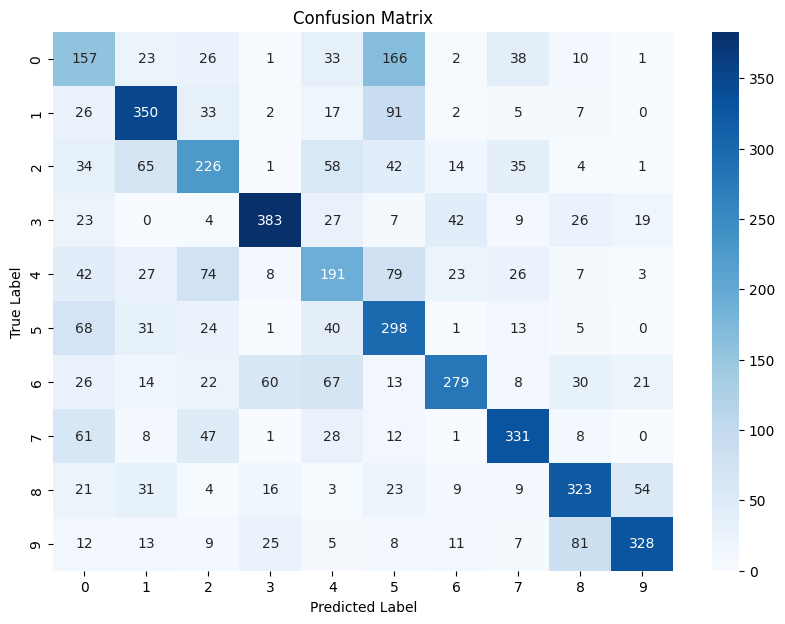


Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.34      0.34       457
           1       0.62      0.66      0.64       533
           2       0.48      0.47      0.48       480
           3       0.77      0.71      0.74       540
           4       0.41      0.40      0.40       480
           5       0.40      0.62      0.49       481
           6       0.73      0.52      0.60       540
           7       0.69      0.67      0.68       497
           8       0.64      0.66      0.65       493
           9       0.77      0.66      0.71       499

    accuracy                           0.57      5000
   macro avg       0.58      0.57      0.57      5000
weighted avg       0.59      0.57      0.58      5000



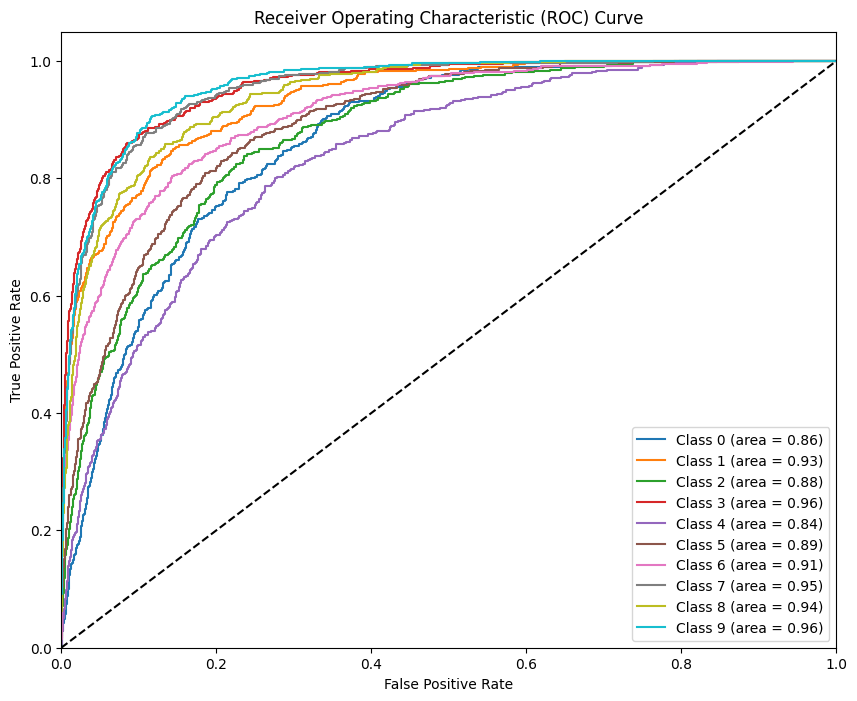

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('\nClassification Report:\n', classification_report(y_val_true_labels, y_val_pred_labels))

# ROC Curve
n_classes = 10
y_val_true_bin = tf.keras.utils.to_categorical(y_val_true_labels, num_classes=n_classes)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_true_bin[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Save submission file
submission = np.column_stack((id_test, y_pred_labels))
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

Confusion Matrix:
- The model is pretty good at predicting Class 1, 3, 7 and 9, yielding 300+ correct predictions. However, the model struggled at predicting class 0 and 4, yielding <200 correct predictions.
- Notably, there are many misclassfications for class 0 where the true label is class 0, but the model predicted it being another class.

Classfication report:
- Class 3 had a high precision (0.77) and recall (0.71), indicating it was predicted accurately and frequently identified when present. In contrast, class 0 had lower precision (0.33) and recall (0.34), meaning it was less accurately predicted and missed frequently when present.
- The F1 score balances precision and recall. Class 3 had a strong F1-score of 0.74, suggesting it was well-handled overall, while class 53 had a lower F1-score of 0.34, indicating poor overall performance.

AUC-ROC scores:
- Classes 3, 7, and 9 had high AUC scores (around 0.96), indicating the model was very good at distinguishing these classes from others.
- Class 0 had an AUC score of 0.86, which, while still relatively high, indicates room for improvement in distinguishing it from other classes.

**Reflection**

In my journey to build a robust machine learning model for image classification, I began with a Multilayer Perceptron (MLP) model, which yielded an accuracy of 0.3421 and a loss of 1.8089, with validation accuracy and loss at 0.3320 and 1.8394 respectively. This initial approach proved insufficient, as the performance metrics highlighted significant shortcomings in the model's ability to generalize beyond the training data. Therefore, I transitioned to a CNN model, which offered the potential for improved accuracy by leveraging the spatial hierarchies in image data. Despite this, the CNN model initially faced challenges, including overfitting and suboptimal performance. The confusion matrix indicated imbalanced performance across different classes, while the classification report revealed varied F1-scores, with some classes performing notably worse than others. The ROC curve analysis further suggested that the model's performance, while better than random guessing, was still limited, with AUC scores around 0.5. To address these issues, I implemented several improvements, including reducing the learning rate, applying data augmentation techniques to increase the model’s exposure to diverse data patterns, and training the model for 50 epochs. These steps led to notable enhancements in performance, with the CNN model achieving an accuracy of 0.5404 and a loss of 1.3932, alongside a validation accuracy of 0.5732 and a validation loss of 1.3374. The final model demonstrated more balanced performance across classes, and the AUC-ROC score went up to >0.8 for all classes, indicating that the model can distinguish classes fairly well. However, there are challenges remain. Future steps to further enhance the model could involve exploring more advanced architectures, such as deeper CNNs or hybrid models, employing additional regularization techniques to combat overfitting, and tuning hyperparameters more extensively. Additionally, incorporating more sophisticated data augmentation strategies and experimenting with different optimization algorithms might help in improving the overall accuracy and generalizability of the model.